# Run inference on one frame
Then evaluate

In [19]:
from mmdet3d.apis import LidarDet3DInferencer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [20]:
# Initialize inferencer
inferencer = LidarDet3DInferencer('pointpillars_kitti-3class')

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection3d/v1.0.0_models/pointpillars/hv_pointpillars_secfpn_6x8_160e_kitti-3d-3class/hv_pointpillars_secfpn_6x8_160e_kitti-3d-3class_20220301_150306-37dc2420.pth


/home/rachel/mmdetection3d/mmdet3d/models/dense_heads/anchor3d_head.py:94: UserWarning: dir_offset and dir_limit_offset will be depressed and be incorporated into box coder in the future
  warnings.warn(
/home/rachel/miniconda3/envs/openmm_mmvc/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


In [21]:
# inference
frame = '006000'
bin_path = '../../mmdetection3d/data/arcs/training/velodyne/' + frame + '.bin'
label_path = '../data/pillar_pred_format_labels/' + frame + '.txt'
points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
print(points)

[[ 1.9951080e+00  7.4210228e+01  6.0603518e+00  1.0980392e-01]
 [ 1.9961680e+00  7.5227097e+01  3.0659101e+00  1.5294118e-01]
 [-7.1061258e+00  9.9135567e+01  2.8925300e+00  1.6862746e-01]
 ...
 [ 2.3078500e-01  9.9404068e+00 -1.9886290e+00  5.4901961e-02]
 [-1.9081500e-01  7.3855128e+00 -2.0681820e+00  5.0980393e-02]
 [ 9.5726997e-02  4.1860480e+00 -1.9524970e+00  1.5294118e-01]]


In [22]:
inputs = dict(points=bin_path)

In [23]:
print(inputs)

{'points': '../../mmdetection3d/data/arcs/training/velodyne/006000.bin'}


In [24]:
def convert_to_dataframe(bin_path):
    pre_filtered_data = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4) 
    columns = ['x', 'y', 'z', 'intensity']
    df = pd.DataFrame(pre_filtered_data, columns=columns)
    return df

In [25]:
points = convert_to_dataframe(bin_path)
print(points)

              x          y         z  intensity
0      1.995108  74.210228  6.060352   0.109804
1      1.996168  75.227097  3.065910   0.152941
2     -7.106126  99.135567  2.892530   0.168627
3     -2.260264  98.091408  2.283138   0.109804
4      1.985014  75.302368  1.314864   0.152941
...         ...        ...       ...        ...
52492  0.379432  16.220654 -2.065243   0.031373
52493 -0.332121  13.030959 -2.027973   0.031373
52494  0.230785   9.940407 -1.988629   0.054902
52495 -0.190815   7.385513 -2.068182   0.050980
52496  0.095727   4.186048 -1.952497   0.152941

[52497 rows x 4 columns]


In [26]:
np_points = points.values
print(np_points)

[[ 1.9951080e+00  7.4210228e+01  6.0603518e+00  1.0980392e-01]
 [ 1.9961680e+00  7.5227097e+01  3.0659101e+00  1.5294118e-01]
 [-7.1061258e+00  9.9135567e+01  2.8925300e+00  1.6862746e-01]
 ...
 [ 2.3078500e-01  9.9404068e+00 -1.9886290e+00  5.4901961e-02]
 [-1.9081500e-01  7.3855128e+00 -2.0681820e+00  5.0980393e-02]
 [ 9.5726997e-02  4.1860480e+00 -1.9524970e+00  1.5294118e-01]]


In [27]:
predictions = inferencer(dict(points=np_points))

Output()

In [28]:
print(predictions)

{'predictions': [{'labels_3d': [1, 2, 2, 2, 2, 2], 'scores_3d': [0.37436285614967346, 0.8860181570053101, 0.846523106098175, 0.5451850891113281, 0.4473717212677002, 0.4247516095638275], 'bboxes_3d': [[5.028863430023193, -15.78142261505127, -0.721443772315979, 1.7926948070526123, 0.6943190097808838, 1.7274187803268433, 1.5951296091079712], [2.158820867538452, 25.521644592285156, -2.0219573974609375, 4.410659313201904, 1.713751196861267, 1.4779202938079834, -1.0621992349624634], [10.126334190368652, 26.06059455871582, -1.8438267707824707, 4.386297225952148, 1.6843407154083252, 1.5065099000930786, 2.106016159057617], [29.500598907470703, -14.849691390991211, 0.2762340307235718, 4.206188201904297, 1.5862056016921997, 1.5070021152496338, 2.1125431060791016], [28.044879913330078, -20.803447723388672, 0.47694647312164307, 4.386697292327881, 1.6085255146026611, 1.3169963359832764, 1.2406989336013794], [31.531211853027344, -25.256420135498047, 0.4247567653656006, 4.498119831085205, 1.6615589857

In [121]:
def set_axes_limited(ax, limit=50):
    # Set axes to a fixed range around the origin to limit view to +/- 'limit' meters.
    ax.set_xlim3d([-limit, limit])
    ax.set_ylim3d([-limit, limit])
    ax.set_zlim3d([-limit, limit])

In [124]:
def set_axes_limited(ax, limit=50):
    # Set axes to a fixed range around the origin to limit view to +/- 'limit' meters.
    ax.set_xlim3d([-5, 20])
    ax.set_ylim3d([15, 40])
    ax.set_zlim3d([-5, 20])

In [30]:
def set_axes_equal(ax):
    """Make axes of 3D plot have equal scale so that spheres appear as spheres, cubes as cubes, etc."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    box_size = max([x_range, y_range, z_range]) / 2.0

    ax.set_xlim3d([x_middle - box_size, x_middle + box_size])
    ax.set_ylim3d([y_middle - box_size, y_middle + box_size])
    ax.set_zlim3d([z_middle - box_size, z_middle + box_size])

In [31]:
# Function to plot the bounding box
def plot_bbox(ax, bbox, color):
    
    x, y, z, dx, dy, dz, yaw = bbox

    
    corners = np.array([
        [x - dx/2, y - dy/2, z - dz/2],
        [x + dx/2, y - dy/2, z - dz/2],
        [x + dx/2, y + dy/2, z - dz/2],
        [x - dx/2, y + dy/2, z - dz/2],
        [x - dx/2, y - dy/2, z + dz/2],
        [x + dx/2, y - dy/2, z + dz/2],
        [x + dx/2, y + dy/2, z + dz/2],
        [x - dx/2, y + dy/2, z + dz/2]
    ])
    

    # Rotate corners around the Z-axis (around their centers)
    rotation_matrix = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw),  np.cos(yaw), 0],
        [0,            0,           1]
    ])

    # # Adjust the corners to be about the origin for rotation, then add the [x, y, z] back after rotation
    corners = corners - np.array([x, y, z])
    corners = np.dot(corners, rotation_matrix.T)
    corners += np.array([x, y, z])
    
    # Define the edges of the bounding box
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),
        (4, 5), (5, 6), (6, 7), (7, 4),
        (0, 4), (1, 5), (2, 6), (3, 7)
    ]
    # Plot the edges
    for edge in edges:
        ax.plot3D(*zip(corners[edge[0]], corners[edge[1]]), color=color, linewidth=1)

In [99]:
def read_kitti_labels(label_path):
    bboxes = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if parts[0] != 'DontCare':
                bbox = [float(value) for value in parts[8:15]]  # Extract the bounding box dimensions and location
                bboxes.append(bbox)
#     print(bboxes)
    return np.array(bboxes)

In [33]:
def rotate_point(point, angle):
    c, s = np.cos(angle), np.sin(angle)
    R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
    return np.dot(R, point)

In [34]:
# This function should convert the x, y, z, length, width, height, yaw values
# into 8 corner points (which is the format needed to computer IoU with the pytorch3d library)
def get_box_corners(x, y, z, length, width, height, yaw):
    corners = np.array([
        [length/2, width/2, height/2],
        [length/2, width/2, -height/2],
        [length/2, -width/2, height/2],
        [length/2, -width/2, -height/2],
        [-length/2, width/2, height/2],
        [-length/2, width/2, -height/2],
        [-length/2, -width/2, height/2],
        [-length/2, -width/2, -height/2]
    ])
    rotated_corners = np.array([rotate_point(corner, yaw) for corner in corners])
    translated_corners = rotated_corners + np.array([x, y, z])
#     print(translated_corners)
    return translated_corners

In [35]:
print(points)

              x          y         z  intensity
0      1.995108  74.210228  6.060352   0.109804
1      1.996168  75.227097  3.065910   0.152941
2     -7.106126  99.135567  2.892530   0.168627
3     -2.260264  98.091408  2.283138   0.109804
4      1.985014  75.302368  1.314864   0.152941
...         ...        ...       ...        ...
52492  0.379432  16.220654 -2.065243   0.031373
52493 -0.332121  13.030959 -2.027973   0.031373
52494  0.230785   9.940407 -1.988629   0.054902
52495 -0.190815   7.385513 -2.068182   0.050980
52496  0.095727   4.186048 -1.952497   0.152941

[52497 rows x 4 columns]


<class 'list'>
[array([ 2.26, 25.69, -1.4 ,  2.46,  5.19,  2.55,  0.53]), array([10.2 , 26.15, -1.04,  2.12,  4.7 ,  2.56,  3.63])]


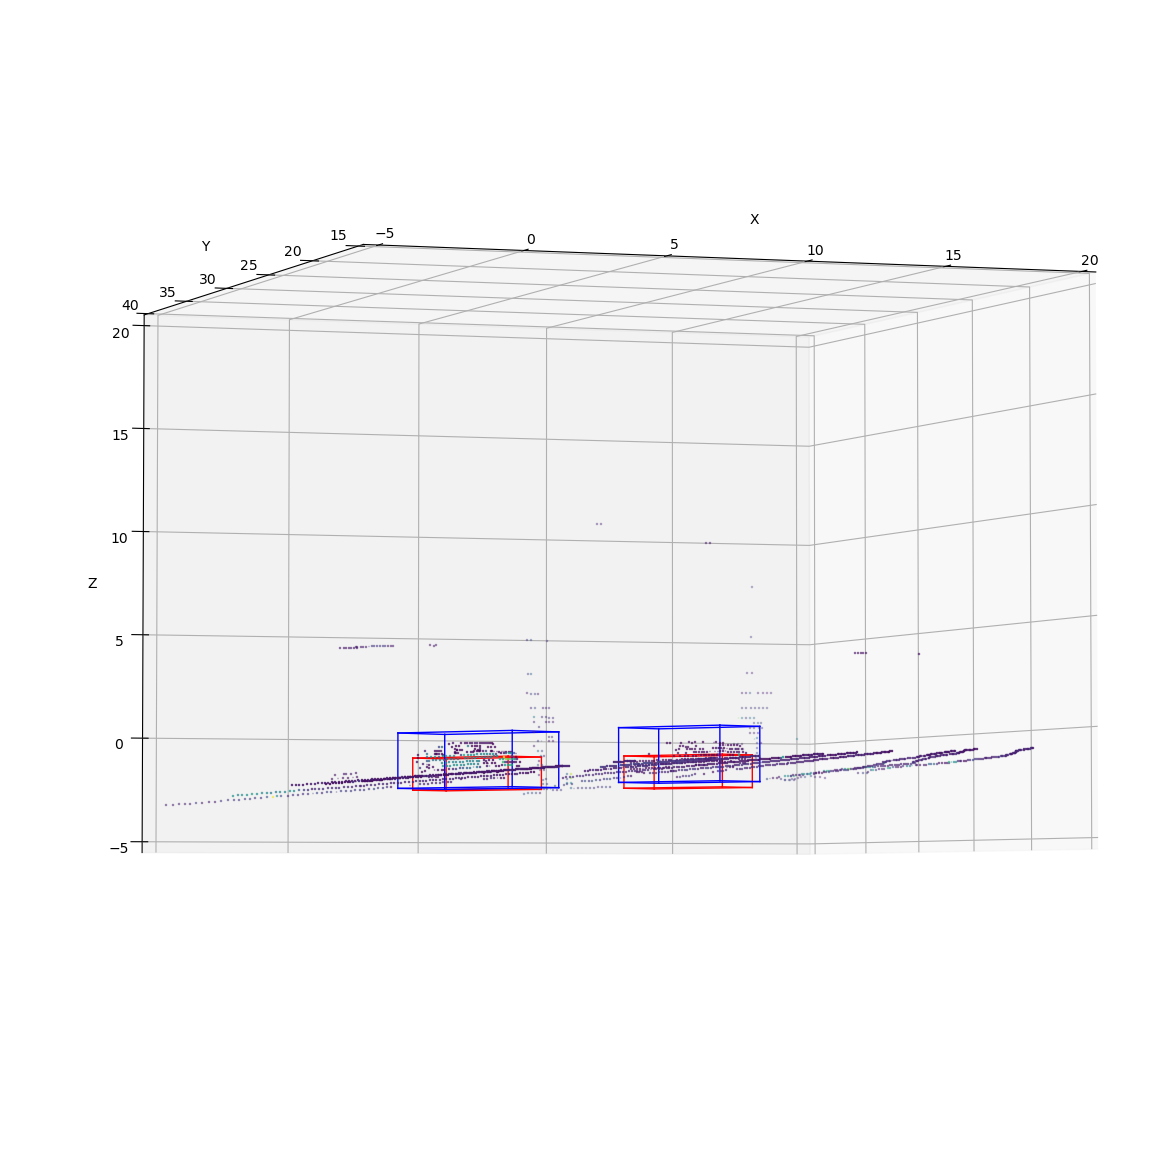

In [132]:
# Set up the plot
# fig = plt.figure(figsize=(40, 40))
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(111, projection='3d')

# Define your limits
x_limits = [-5, 20]
y_limits = [15, 40]
z_limits = [-5, 20]

# Filter points within these limits
filtered_points = points[
    (points['x'] >= x_limits[0]) & (points['x'] <= x_limits[1]) &
    (points['y'] >= y_limits[0]) & (points['y'] <= y_limits[1]) &
    (points['z'] >= z_limits[0]) & (points['z'] <= z_limits[1])
]

# Now scatter these filtered points
ax.scatter(filtered_points['x'], filtered_points['y'], filtered_points['z'], s=0.5, c=filtered_points['intensity'], cmap='viridis', marker=',')

# ax.scatter(points['x'], points['y'], points['z'], s=0.1, c=points['intensity'], cmap='viridis', marker=',')

score_threshold = 0.23

# Plot each bounding box with score above threshold
for pred in predictions['predictions']:
    for label, score, bbox in zip(pred['labels_3d'], pred['scores_3d'], pred['bboxes_3d']):
        if score > score_threshold and label == 2:
            plot_bbox(ax, bbox, 'r')
            
corner_points = []
# Plot ground truth
boxes_to_plot = list(read_kitti_labels(label_path))[:1] + list(read_kitti_labels(label_path))[2:3]
print(type(boxes_to_plot))
print(boxes_to_plot)

# for bbox in read_kitti_labels(label_path):
for bbox in boxes_to_plot:
    # And corners points to list(to check that that function is working)
    corners = get_box_corners(bbox[0], bbox[1], bbox[2], bbox[3], bbox[4], bbox[5], bbox[6])
    for corner in corners:
        corner_points.extend(corner)
    plot_bbox(ax, bbox, 'b')
    
# Plot corners
# print(corner_points)
# corner_points_np = np.array(corner_points).reshape(-1, 3)
# ax.scatter(corner_points_np[:, 0], corner_points_np[:, 1], corner_points_np[:, 2], s=200, c='r', marker='^')
            
# Setting axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
set_axes_equal(ax)

# Setting axes properties with a limited range
set_axes_limited(ax)

# Adjust the view angle if needed
ax.view_init(elev=-3, azim=250)

# Show the plot
plt.show()

# Save the figure
# fig.savefig('3d_scatter_with_bboxes.png', dpi=300)

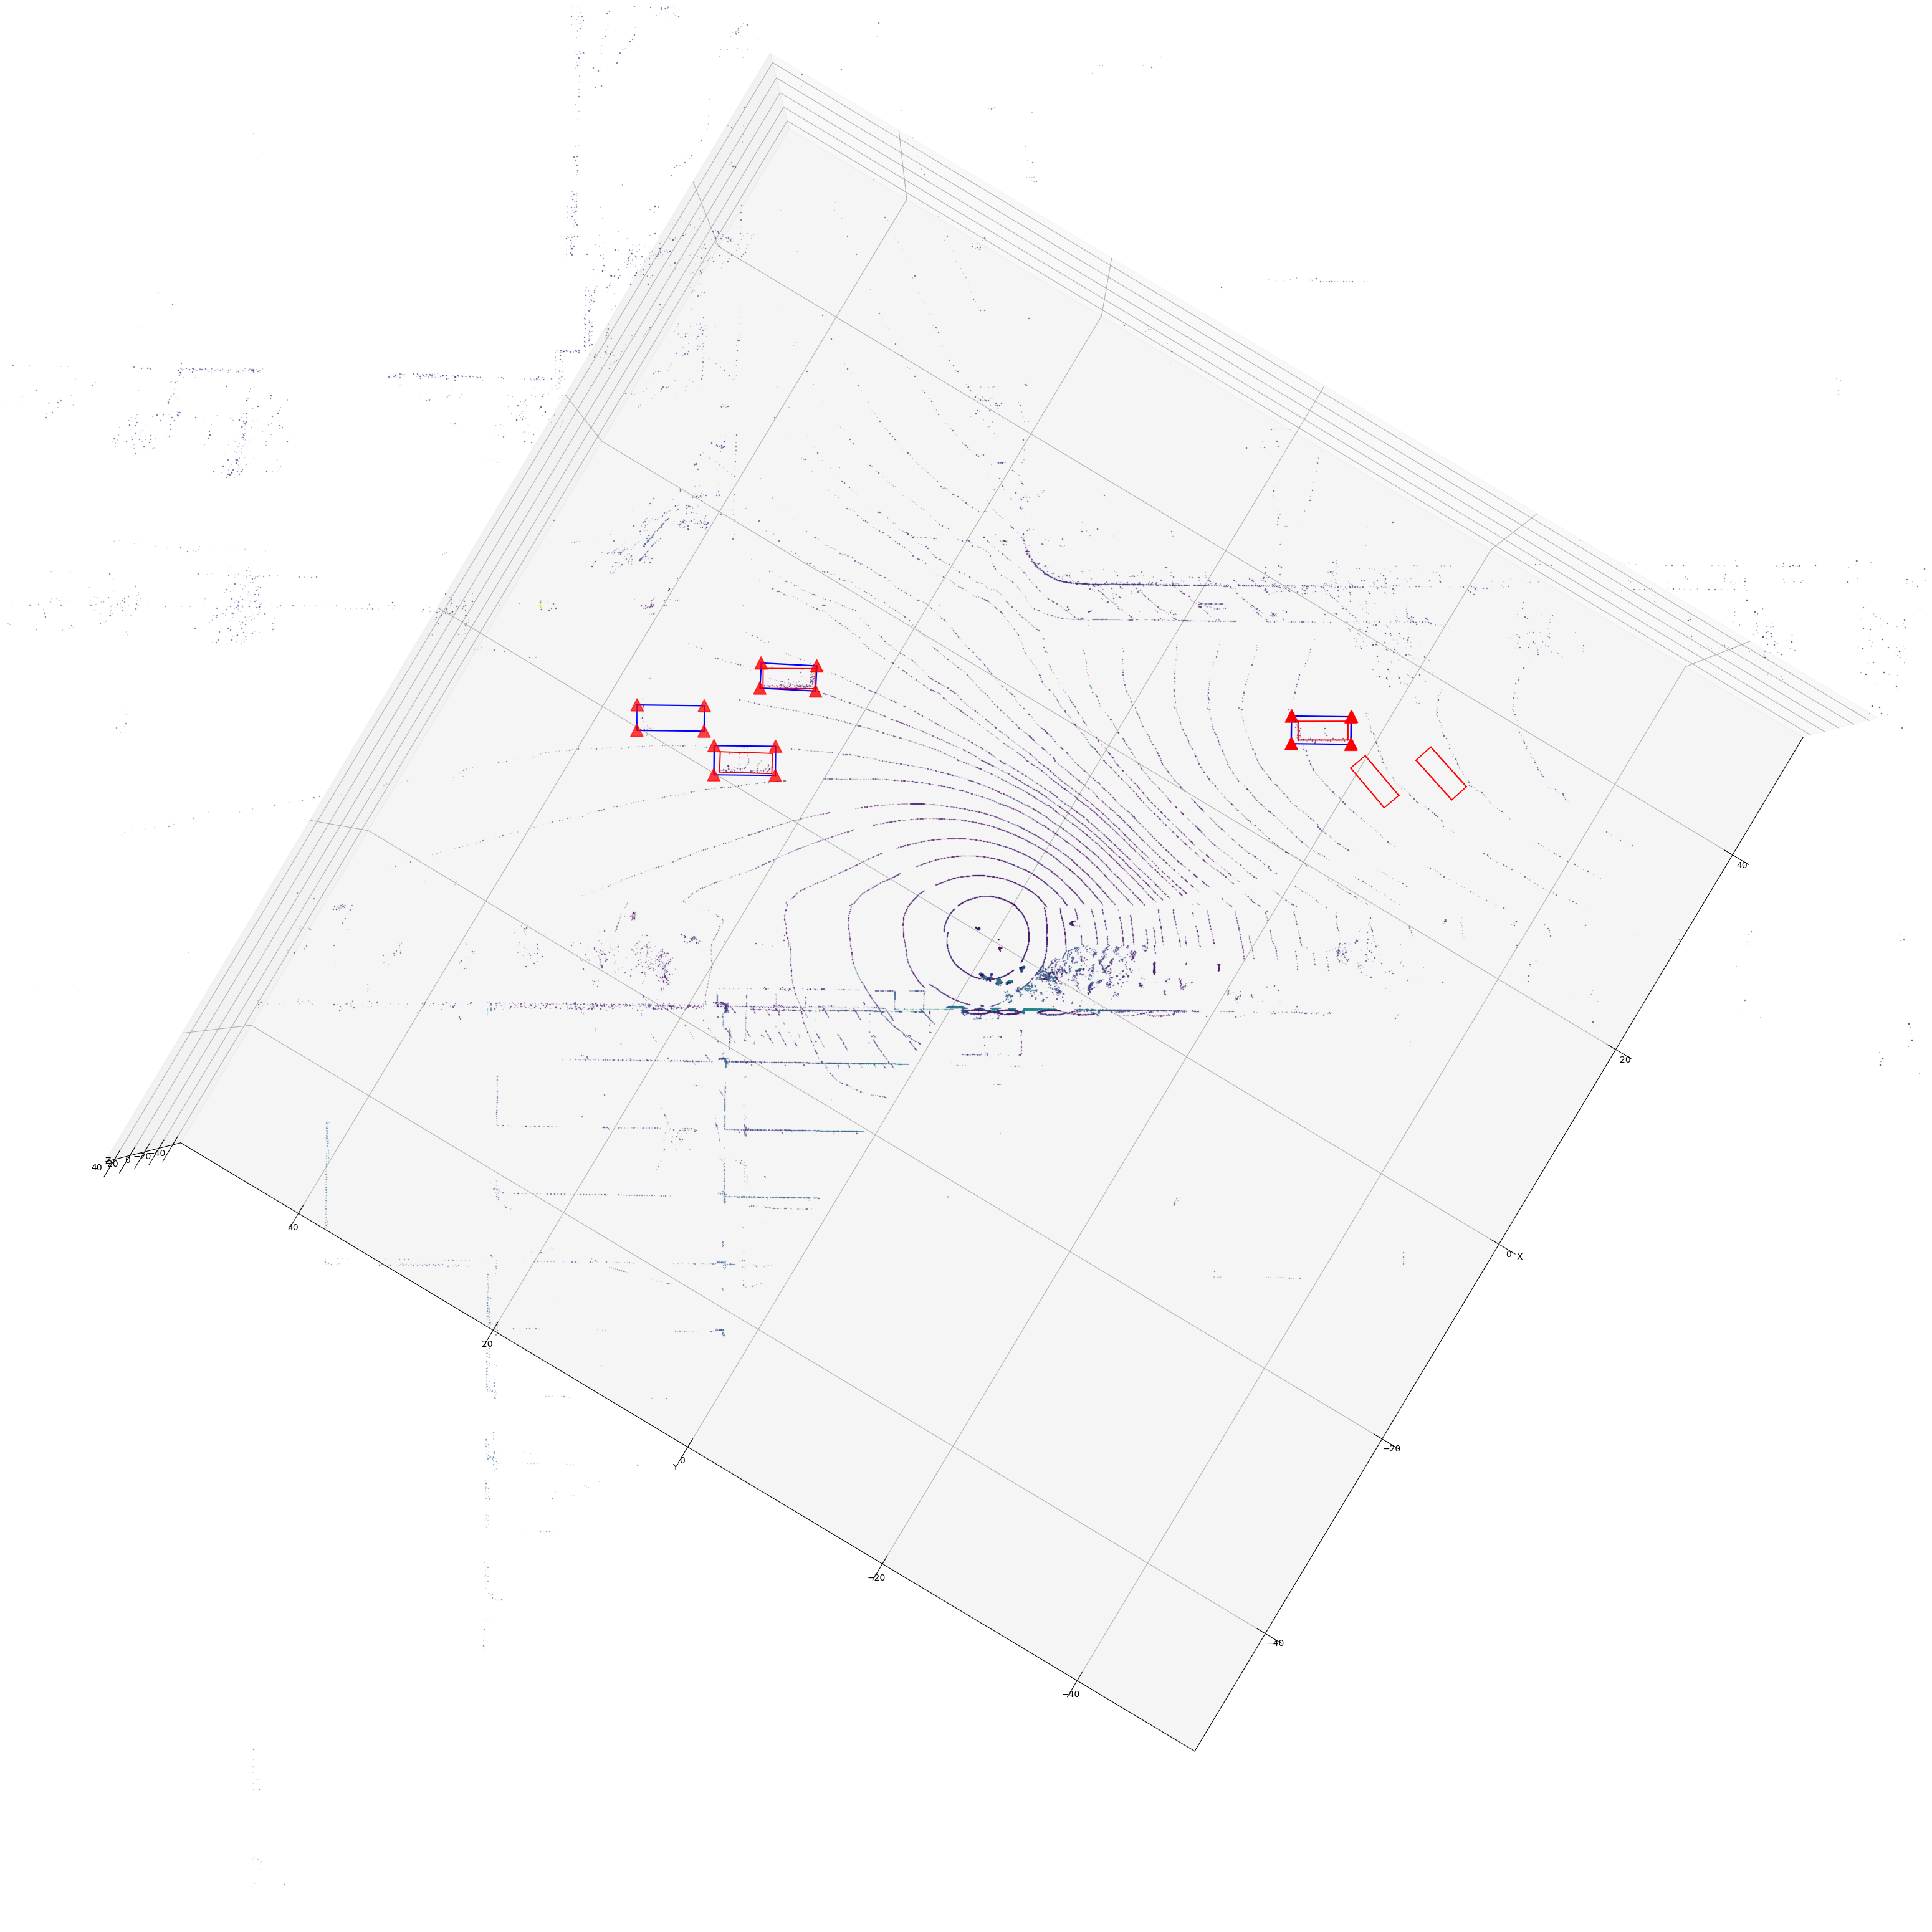

In [122]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(points['x'], points['y'], points['z'], s=0.1, c=points['intensity'], cmap='viridis', marker=',')

score_threshold = 0.23

# Plot each bounding box with score above threshold
for pred in predictions['predictions']:
    for label, score, bbox in zip(pred['labels_3d'], pred['scores_3d'], pred['bboxes_3d']):
        if score > score_threshold and label == 2:
            plot_bbox(ax, bbox, 'r')
            
corner_points = []
# Plot ground truth

for bbox in read_kitti_labels(label_path):
    # And corners points to list(to check that that function is working)
    corners = get_box_corners(bbox[0], bbox[1], bbox[2], bbox[3], bbox[4], bbox[5], bbox[6])
    for corner in corners:
        corner_points.extend(corner)
    plot_bbox(ax, bbox, 'b')
    
# Plot corners
# print(corner_points)
corner_points_np = np.array(corner_points).reshape(-1, 3)
ax.scatter(corner_points_np[:, 0], corner_points_np[:, 1], corner_points_np[:, 2], s=200, c='r', marker='^')
            
# Setting axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
set_axes_equal(ax)

# Setting axes properties with a limited range
set_axes_limited(ax)

# Adjust the view angle if needed
ax.view_init(elev=90, azim=210)

# Show the plot
plt.show()

# Save the figure
# fig.savefig('3d_scatter_with_bboxes.png', dpi=300)

## Try bbox library

In [37]:
import bbox as bboxlib
import math

In [38]:
# The 3D bbox object requires quaternion values. This function converts the yaw to these values
def yaw_to_quaternion(yaw):
    """
    Converts a yaw angle (rotation about the z-axis) to quaternion coordinates.
    
    Parameters:
    - yaw (float): The yaw angle in radians.
    
    Returns:
    - tuple of (rw, rx, ry, rz): The quaternion representation of the yaw.
    """
    # Compute the components of the quaternion
    rw = math.cos(yaw / 2.0)
    rz = math.sin(yaw / 2.0)
    
    # rx and ry are zero because the rotation is only about the z-axis
    return (rw, 0, 0, rz)

In [39]:
# This function takes x, y, z, dx, dy, dz, yaw and returns a 3D bbox object from the bbox package
# Yaw is in radians
def get3DBbox(x, y, z, dx, dy, dz, yaw):
    # Example usage:
    rw, rx, ry, rz = yaw_to_quaternion(yaw)
    bbox_obj = bboxlib.BBox3D(x, y, z, length=dx, width=dy, height=dz, rw=rw, rx=rx, ry=ry, rz=rz)
    return bbox_obj

In [40]:
bbox_label = get3DBbox(2.26, 25.69, -1.4, 2.46, 5.19, 2.55, 0.53)
bbox_pred_0 = get3DBbox(5.028863430023193, -15.78142261505127, -0.721443772315979, 
                        1.7926948070526123, 0.6943190097808838, 1.7274187803268433, 1.5951296091079712)
print(bboxlib.metrics.jaccard_index_3d(bbox_label, bbox_pred_0))

bbox_pred_1 = get3DBbox(2.158820867538452, 25.521644592285156, -2.0219573974609375, 
                        4.410659313201904, 1.713751196861267, 1.4779202938079834, -1.0621992349624634)
print(bboxlib.metrics.jaccard_index_3d(bbox_label, bbox_pred_1))


bbox_pred_2 = get3DBbox(10.126334190368652, 26.06059455871582, -1.8438267707824707, 
                        4.386297225952148, 1.6843407154083252, 1.5065099000930786, 2.106016159057617)
print(bboxlib.metrics.jaccard_index_3d(bbox_label, bbox_pred_2))


bbox_pred_3 = get3DBbox(29.500598907470703, -14.849691390991211, 0.2762340307235718, 
                        4.206188201904297, 1.5862056016921997, 1.5070021152496338, 2.1125431060791016)
print(bboxlib.metrics.jaccard_index_3d(bbox_label, bbox_pred_3))


bbox_pred_4 = get3DBbox(28.044879913330078, -20.803447723388672, 0.47694647312164307, 
                        4.386697292327881, 1.6085255146026611, 1.3169963359832764, 1.2406989336013794)
print(bboxlib.metrics.jaccard_index_3d(bbox_label, bbox_pred_4))


bbox_pred_5 = get3DBbox(31.531211853027344, -25.256420135498047, 0.4247567653656006, 
                        4.498119831085205, 1.661558985710144, 1.4026427268981934, 4.414409637451172)
print(bboxlib.metrics.jaccard_index_3d(bbox_label, bbox_pred_5))

0
0.34313
0
0
0
0


In [41]:
def calculate_iou(bbox1, bbox2):
    bbox_obj1 = get3DBbox(*bbox1)
    bbox_obj2 = get3DBbox(*bbox2)
    return bboxlib.metrics.jaccard_index_3d(bbox_obj1, bbox_obj2)

In [42]:
# def parse_predictions(prediction):
#     return prediction

In [43]:
def parse_ground_truths(label_path):
    labels = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            bbox = []
            # Add the category as a string
            bbox.append(parts[0])
            # Extract the bounding box dimensions and location as 
            bbox = bbox + [float(value) for value in parts[1:15]]  
            bbox[2] = int(bbox[2])
            labels.append(bbox)
    return labels

In [44]:
def evaluate_model(predictions, ground_truths, threshold=0.5):
    TPs, FPs, FNs = 0, 0, len(ground_truths)
    used_gt = set()
    
    for pred in predictions['predictions']:
        for label, score, bbox in zip(pred['labels_3d'], pred['scores_3d'], pred['bboxes_3d']):
            if score < threshold:
                continue
        
            best_iou = 0
            best_gt = None
            for gt in ground_truths:
                iou = calculate_iou(bbox, gt[8:])
                print(iou)
                if iou > best_iou:
                    best_iou = iou
                    best_gt = tuple(gt)

            if best_iou > 0.25:  # Example IoU threshold for a match
                if best_gt not in used_gt:
                    used_gt.add(best_gt)
                    TPs += 1
                    FNs -= 1
                else:
                    FPs += 1
            else:
                FPs += 1

    precision = TPs / (TPs + FPs) if TPs + FPs > 0 else 0
    recall = TPs / (TPs + FNs) if TPs + FNs > 0 else 0
    return precision, recall

In [45]:
# Example usage
# predictions = parse_predictions(predictions)
ground_truths = parse_ground_truths(label_path)
precision, recall = evaluate_model(predictions, ground_truths)

0.34313
0
0
0
0
0
0.43634
0
0
0
0
0.32636


In [46]:
print(precision)
print(recall)

1.0
0.75


# <3 <3 <3 <3 <3 <3 <3 <3 <3 <3 <3 <3

# Check volumes of different boxes

In [70]:
def get_pred_gt_pairs(predictions, ground_truths, threshold=0.5):
    list_pred_gt_pairs = []
    used_gt = set()
    
    for pred in predictions['predictions']:
        for label, score, bbox in zip(pred['labels_3d'], pred['scores_3d'], pred['bboxes_3d']):
            if score < threshold:
                continue
        
            best_iou = 0
            best_gt = None
            for gt in ground_truths:
                iou = calculate_iou(bbox, gt[8:])
                print(iou)
                if iou > best_iou:
                    best_iou = iou
                    best_gt = tuple(gt)

            if best_iou > 0.25:  # Example IoU threshold for a match
                if best_gt not in used_gt:
                    used_gt.add(best_gt)
                    # Add pair to list
                    list_pred_gt_pairs.append([bbox, list(best_gt[8:])])

    return list_pred_gt_pairs

In [71]:
list_pred_gt_pairs = get_pred_gt_pairs(predictions, ground_truths)

0.34313
0
0
0
0
0
0.43634
0
0
0
0
0.32636


In [73]:
def get_volume(bounding_box):
    x, y, z, dx, dy, dz, yaw = bounding_box
    return dx * dy * dz

In [87]:
def get_max_possible_iou(bbox1, bbox2):
    volume1 = get_volume(bbox1)
    volume2 = get_volume(bbox2)
    if volume1 > volume2:
        return volume2 / volume1    
    else:
        return volume1 / volume2

In [88]:
def get_bbox_comparison(list_pred_gt_pairs):
    results = []
    
    num_pairs = len(list_pred_gt_pairs)
    total_pred_volume = 0
    total_gt_volume = 0
    total_iou = 0
    total_max_iou = 0

    # For each pair in the list
    for pair in list_pred_gt_pairs:
        # Calculate the volume of each
        pred_volume = get_volume(pair[0])
        total_pred_volume += pred_volume
        gt_volume = get_volume(pair[1])
        total_gt_volume += gt_volume
        
        # Get the actual IoU
        iou = calculate_iou(pair[0], pair[1])
        total_iou += iou
        
        # Get the maximum possible IoU    
        max_possible_iou = get_max_possible_iou(pair[0], pair[1])
        total_max_iou += max_possible_iou
        
        results_dict = {
            'pred_volume': pred_volume,
            'gt_volume': gt_volume,
            'iou': iou,
            'max_possible_iou': max_possible_iou,
        }
        
        results.append(results_dict)
    
    summary_dict = {
        'avg_pred_volume': total_pred_volume / num_pairs,
        'avg_gt_volume': total_gt_volume / num_pairs,
        'avg_iou': total_iou / num_pairs,
        'avg_max_possible_iou': total_max_iou / num_pairs,
    }
    
    return results, summary_dict

In [89]:
results, summary = get_bbox_comparison(list_pred_gt_pairs)

In [90]:
results_df = pd.DataFrame(results)
display(results_df)

,pred_volume,gt_volume,iou,max_possible_iou
0,11.171264,32.556870,0.34313,0.343131
1,11.130124,25.507840,0.43634,0.436341
2,10.054536,30.807744,0.32636,0.326364


In [91]:
summary_df = pd.DataFrame([summary])
display(summary_df)

,avg_pred_volume,avg_gt_volume,avg_iou,avg_max_possible_iou
0,10.785308,29.624151,0.36861,0.368612


## Test evaluation box

Center (x, y, z): (-12.959999999999999, 11.717499999999998, -0.39250000000000007)
Dimensions (l, w, h): (77.99, 55.934999999999995, 7.535)
Center (x, y, z): (13.0175, 11.717499999999998, -0.39250000000000007)
Dimensions (l, w, h): (26.035, 55.934999999999995, 7.535)

In [ ]:
evaluation_area = [-12.959, 11.71749, -0.3925, 77.99, 55.9349, 7.535, 0]
evaluation_area = [13.0175, 11.717, -0.3925, 26.035, 55.9349, 7.535, 0]
evaluation_area = [13.0175, 11.717, -0.3925, 26.035, 55.9349, 7.535, 0.5]
evaluation_area = [13.0175, 11.717, -0.3925, 36.035, 55.9349, 7.535, 0.5]
evaluation_area = [23.0175, 11.717, -0.3925, 36.035, 55.9349, 7.535, 0.5]
evaluation_area = [21.0175, 11.717, -0.3925, 40.035, 55.9349, 7.535, 0.5]

In [ ]:
# Draw evaluation area box over point cloud
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=0.1, c=points[:, 3], cmap='viridis', marker=',')

score_threshold = 0.23

# Plot each bounding box with score above threshold
for pred in predictions['predictions']:
    for label, score, bbox in zip(pred['labels_3d'], pred['scores_3d'], pred['bboxes_3d']):
        if score > score_threshold and label == 2:
#         if score > score_threshold:
            plot_bbox(ax, bbox, 'r')

# Draw evaluation area over the point clouds
plot_bbox(ax, evaluation_area, 'r')

            
# Setting axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
set_axes_equal(ax)

# Setting axes properties with a limited range
set_axes_limited(ax)

# Show the plot
plt.show()

In [ ]:
# Returns true if the pending box overlaps the evaluation area
def is_in_eval_area(eval_bbox, pending_bbox):
    iou = calculate_iou(eval_bbox, pending_bbox)
    if iou > 0:
        return True
    return False

In [ ]:
# Highlight the boxes that overlap the evaluation area
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Adjust the viewing angle
ax.view_init(elev=30, azim=45)

ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=0.1, c=points[:, 3], cmap='viridis', marker=',')

score_threshold = 0.23

# Plot each bounding box with score above threshold
for pred in predictions['predictions']:
    for label, score, bbox in zip(pred['labels_3d'], pred['scores_3d'], pred['bboxes_3d']):
        if score > score_threshold and label == 2:
            if is_in_eval_area(evaluation_area, bbox):
                plot_bbox(ax, bbox, 'r')
            else:
                plot_bbox(ax, bbox, 'b')

# Draw evaluation area over the point clouds
plot_bbox(ax, evaluation_area, 'r')

            
# Setting axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
set_axes_equal(ax)

# Setting axes properties with a limited range
set_axes_limited(ax)

# Show the plot
plt.show()

# Sutherland-Hodgeman

In [134]:
from pytorch3d.ops import box3d_overlap

ModuleNotFoundError: No module named 'pytorch3d'